In [106]:
import collections
import pandas as pd
import networkx as nx
import itertools
import numpy as np

In [107]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as lines

%matplotlib inline

In [151]:
font = {'weight': 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)

In [109]:
pd_df = pd.read_json('../data/data_nov_2017_clean.json')
anarchy = pd.read_csv('../data/anarchy_df.csv')
auction = pd.read_csv('../data/auction_df.csv')

In [110]:
def lower_authors_names(df):
    df.author = df.author.str.lower()

In [111]:
lower_authors_names(pd_df)

In [112]:
lower_authors_names(anarchy)

In [113]:
lower_authors_names(auction)

Average degree over time
-------------------------

In [117]:
def get_average_degree_over_time(df):
    years = []
    av_degree = []
    median_degree = []
    for y in df['date'].sort_values().unique():
        years.append(y)
        temp = df[df['date'].isin(years)]
    
        pairs = []
        for _, d in temp.groupby('unique_key'):
            pairs += tuple(sorted(list(itertools.combinations(d['author'].unique(), 2))))
            co_authors = collections.Counter(pairs)
            
        authors_num_papers = temp.groupby(['author', 'unique_key']).size().reset_index().groupby('author').count()
        authors_num_papers = authors_num_papers.drop(0, axis=1)
        
        G = nx.Graph()
        for name, w in zip(temp.author, authors_num_papers['unique_key'].values):
            G.add_node(name, weight=w) 
        for pair in co_authors.items():
            G.add_edge(*pair[0], weight=pair[1])        
        
        order, size = G.order(), G.size() 
        av_degree.append(float( 2 * size / order))
        median_degree.append(np.median([d for n, d in G.degree()]))
    return years, av_degree, median_degree

In [118]:
xs_pd, ys, md_pd = get_average_degree_over_time(pd_df)
xs_an, zs, md_an = get_average_degree_over_time(anarchy)
xd_au, ks, md_au = get_average_degree_over_time(auction)

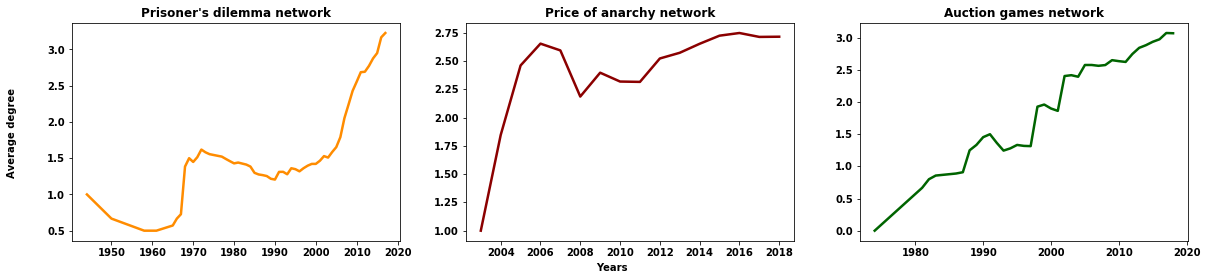

In [171]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
axes[0].plot(xs_pd, ys, color='darkorange', linewidth=2.5) 
axes[0].set_title("Prisoner's dilemma network", fontweight='bold')
axes[0].set_xlim()

axes[1].plot(xs_an, zs,  color='darkred', linewidth=2.5)
axes[1].set_title("Price of anarchy network", fontweight='bold')

axes[2].plot(xd_au, ks, color='darkgreen', linewidth=2.5)
axes[2].set_title("Auction games network", fontweight='bold')

fig.text(0.5, 0.02, 'Years', ha='center')
fig.text(0.08, 0.5, 'Average degree', va='center', rotation='vertical');

plt.savefig('/home/nightwing/rsc/Literature-Article/assets/images/average_degrees_lineplots.pdf', format='pdf', bbox_inches='tight')

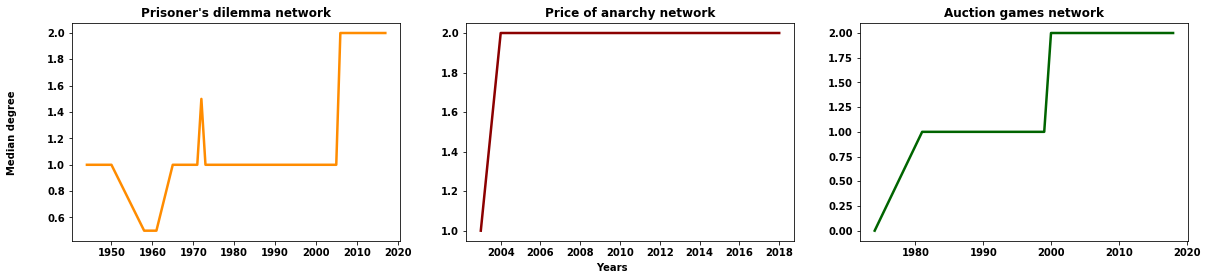

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
axes[0].plot(xs_pd, md_pd, color='darkorange', linewidth=2.5) 
axes[0].set_title("Prisoner's dilemma network", fontweight='bold')
axes[0].set_xlim()

axes[1].plot(xs_an, md_an,  color='darkred', linewidth=2.5)
axes[1].set_title("Price of anarchy network", fontweight='bold')

axes[2].plot(xd_au, md_au, color='darkgreen', linewidth=2.5)
axes[2].set_title("Auction games network", fontweight='bold')

fig.text(0.5, 0.02, 'Years', ha='center')
fig.text(0.08, 0.5, 'Median degree', va='center', rotation='vertical');

plt.savefig('/home/nightwing/rsc/Literature-Article/assets/images/median_degrees_lineplots.pdf', format='pdf', bbox_inches='tight')

Degree distributions
---------------------

In [8]:
G = nx.read_gml('../data/prisoners_network.gml')
Z = nx.read_gml('../data/price_of_anarchy_network.gml')
H = nx.read_gml('../data/auction_network.gml')

In [96]:
pd_distribution = sorted([d for n, d in G.degree()], reverse=True)
anarchy_distribution = sorted([d for n, d in Z.degree()], reverse=True)
auction_distribution = sorted([d for n, d in H.degree()], reverse=True)

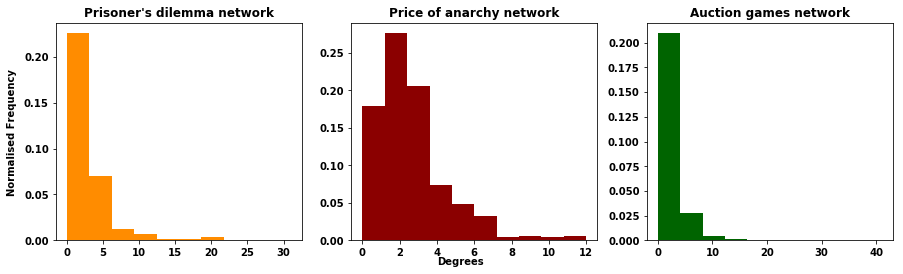

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].hist(pd_distribution,  color='darkorange', normed=True);
axes[0].set_title("Prisoner's dilemma network", fontweight='bold')

axes[1].hist(anarchy_distribution,  color='darkred', normed=True);
axes[1].set_title("Price of anarchy network", fontweight='bold')

axes[2].hist(auction_distribution, color='darkgreen', normed=True);
axes[2].set_title("Auction games network", fontweight='bold')

fig.text(0.5, 0.04, 'Degrees', ha='center')
fig.text(0.08, 0.5, 'Normalised Frequency', va='center', rotation='vertical');

plt.savefig('/home/nightwing/rsc/Literature-Article/assets/images/degrees_histrograms.pdf', format='pdf', bbox_inches='tight')

In [153]:
from scipy import stats

In [167]:
stats.mstats.normaltest(pd_distribution)

NormaltestResult(statistic=1475.9352972210843, pvalue=0.0)

In [168]:
def test_normality(distribution):
    alpha = 0.05
    z, p = stats.mstats.normaltest(distribution)

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected. It is not normally distributed.")
    else:
        print("The null hypothesis cannot be rejected. It is normally distributed.")

In [184]:
def test_medians(distributions):
    alpha = 0.05
    _, p = stats.kruskal(distributions[0],distributions[1], distributions[2])
    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print(p, "The null hypothesis can be rejected.")
    else:
        print(p, "The null hypothesis cannot be rejected.")

In [169]:
test_normality(auction_distribution)

The null hypothesis can be rejected. It is not normally distributed.


In [170]:
stats.kruskal(pd_distribution, anarchy_distribution, auction_distribution)

KruskalResult(statistic=2.4749421266062268, pvalue=0.29011697846926188)

Betweenness centrality comparison
---------------------------------

In [186]:
bc_distributions = [list(nx.betweenness_centrality(graph, weight='weight').values()) for graph in [G, Z, H]]

In [187]:
def get_histrograms_for_centrality(distributions, xtitle, filename=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    axes[0].hist(distributions[0],  color='darkorange', normed=True);
    axes[0].set_title("Prisoner's dilemma network", fontweight='bold')

    axes[1].hist(distributions[1],  color='darkred', normed=True);
    axes[1].set_title("Price of anarchy network", fontweight='bold')

    axes[2].hist(distributions[2], color='darkgreen', normed=True);
    axes[2].set_title("Auction games network", fontweight='bold')

    fig.text(0.5, 0.0, '{}'.format(xtitle), ha='center', fontsize=15)
    fig.text(0.08, 0.5, 'Normalised Frequency', va='center', rotation='vertical');
    
    if filename is not None:
        plt.savefig('/home/nightwing/rsc/Literature-Article/assets/images/{}.pdf'.format(filename),
                    format='pdf', bbox_inches='tight')

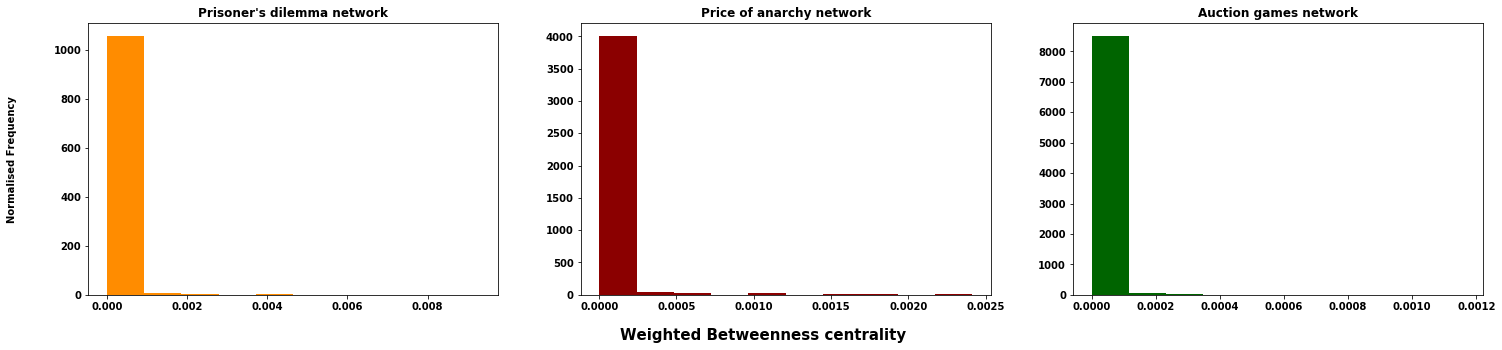

In [188]:
get_histrograms_for_centrality(bc_distributions, xtitle='Weighted Betweenness centrality', 
                               filename='w_betweenness_hist')

In [189]:
cl_distributions = [list(nx.closeness_centrality(graph).values()) for graph in [G, Z, H]]

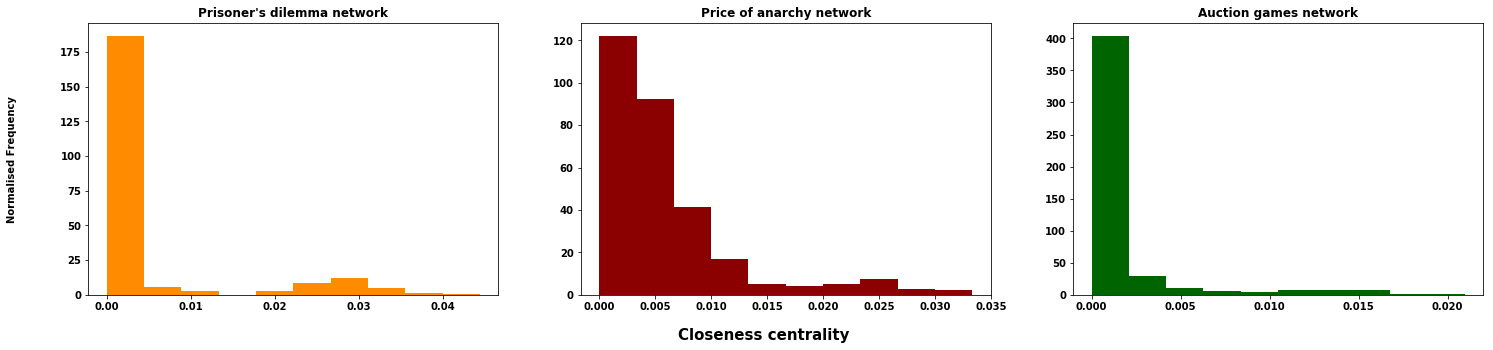

In [190]:
get_histrograms_for_centrality(cl_distributions, xtitle='Closeness centrality',
                               filename='closeness_hist')

In [191]:
pg_distributions = [list(nx.pagerank_numpy(graph, weight='weight').values()) for graph in [G, Z, H]]

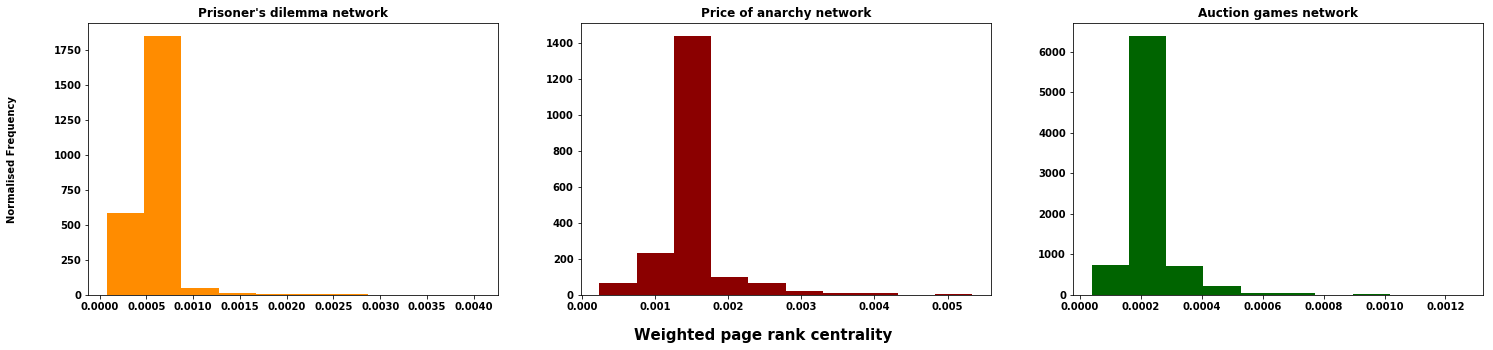

In [192]:
get_histrograms_for_centrality(pg_distributions, xtitle='Weighted page rank centrality',
                               filename='page_rank_hist')

In [178]:
for distr in [*cl_distributions, *bc_distributions, *pg_distributions]:
    test_normality(distr)

The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.
The null hypothesis can be rejected. It is not normally distributed.


In [185]:
for distr in [cl_distributions, bc_distributions, pg_distributions]:
    test_medians(distr)

0.0 The null hypothesis can be rejected.
0.799922035342 The null hypothesis cannot be rejected.
0.0 The null hypothesis can be rejected.


In [202]:
def get_median_centrality(df):
    years = []
    median_b_c = []
    median_c_c = []
    median_p_c = []
    for y in df['date'].sort_values().unique():
        years.append(y)
        temp = df[df['date'].isin(years)]
    
        pairs = []
        for _, d in temp.groupby('unique_key'):
            pairs += tuple(sorted(list(itertools.combinations(d['author'].unique(), 2))))
            co_authors = collections.Counter(pairs)
            
        authors_num_papers = temp.groupby(['author', 'unique_key']).size().reset_index().groupby('author').count()
        authors_num_papers = authors_num_papers.drop(0, axis=1)
        
        G = nx.Graph()
        for name, w in zip(temp.author, authors_num_papers['unique_key'].values):
            G.add_node(name, weight=w) 
        for pair in co_authors.items():
            G.add_edge(*pair[0], weight=pair[1])   
        
        median_b_c.append(np.median(list(nx.betweenness_centrality(G, weight='weight').values())))
        median_c_c.append(np.median(list(nx.closeness_centrality(G).values())))
        median_p_c.append(np.median(list(nx.pagerank_numpy(G, weight='weight').values())))
    return years, [median_b_c, median_c_c, median_p_c]

In [203]:
xs, ys = get_median_centrality(pd_df)